In [1]:
%matplotlib inline
from __future__ import division
import pandas as pd
from pandas.tseries.offsets import *
import numpy as np
import monetdb.sql
from lifelines import CoxPHFitter, AalenAdditiveFitter
from lifelines.utils import k_fold_cross_validation, concordance_index
import patsy
from datetime import date
from scipy.interpolate import InterpolatedUnivariateSpline
import matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression

Load/join dataframes

In [2]:
# Raw loan data
loans = pd.read_csv('data/LoanStats3.csv.bz2', compression='bz2', low_memory=False, index_col=0)
loans.term = loans.term.map(lambda x: int(x.strip(' months')))

# Summarized payment history outcomes
outcomes = pd.read_csv('data/outcomes.csv', low_memory=False)
outcomes.rename(columns={'loan_id': 'id'}, inplace=True)
outcomes.set_index('id', inplace=True)
del outcomes['Unnamed: 0']

# Join on index (loan id)
df = loans.join(outcomes, how='inner')

Using NPV as the survival time can create a very large model, since it has continuous values.
At least AalenAdditiveFitter seems to assume there are relatively few possible survival times.

Dividing NPV into bins by quantile is one way to avoid that issue.  We know each loan "survived" at least as long as the minimum value in its bin, which is how traditional survival data would be gathered.

In [3]:
#df['T'] = df.npv

q = pd.qcut(df.npv, 100)
df['T'] = df.npv.groupby(q).transform(np.min)

df['E'] = df.finalStatusIsComplete.astype(np.float64)

Train a model on 10% of the data (for speed of testing)

It seems that more features and/or row slow it down considerably

In [5]:
samp = df.sample(frac=0.1)
#'term + dti + grade + int_rate + open_acc + inq_last_6mths + revol_util + T + E'
X = patsy.dmatrix('term + dti + grade + T + E',
                  data=samp, return_type='dataframe')

model = AalenAdditiveFitter(coef_penalizer=1.0, fit_intercept=False)
model.fit(X, 'T', 'E')

 [-----------------100%-----------------] 14062 of 14062 complete in 86.5 sec


<lifelines.AalenAdditiveFitter: fitted with 52501 observations, 38439 censored>

Examine predictions for a single loan

expected:            0
0  1.063462
median:  0.114149277421
predict:  0.114149277421
0.997325381382
{'length': 100, 'mean': 0.068887008098456409, 'variance': 0.032400486349297972}


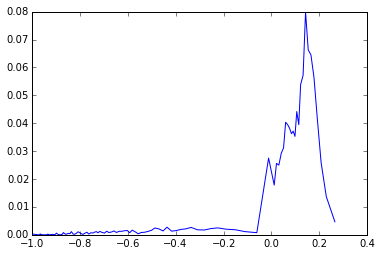

In [8]:
i=0
x = X.iloc[i]

# Built-in metrics
# The expectation doesn't make sense to me, but the others could be useful.
print('expectation: ', model.predict_expectation(x.drop(['T','E']).reshape((1,-1))))
print('median: ', model.predict_median(x.drop(['T','E']).reshape((1,-1))))
print('predict: ', model.predict(x.drop(['T','E']).reshape((1,-1))))

# Survival function
survival = model.predict_survival_function(x.drop(['T','E']).reshape((1,-1)))

# The predictions can jump up and down, which isn't valid.
# We need to transform them so that the diff will give all non-negative probabilities.
ir = IsotonicRegression(increasing=False, out_of_bounds='clip')
ir.fit(survival.index, survival[0])
survivalDecreasing = ir.transform(survival.index)

# The probability of npv falling within the surv.index[0] bin should be 1-survivalDecreasing[0].
# Then the probability for surv.index[i] should be surivivalDecreasing[i] - survivalDecreasing[i-1]
p = -np.diff(np.concatenate(([1], survivalDecreasing)))
#print(pd.DataFrame({'surv':survival[0], 'p':p, 'survDec': survivalDecreasing}))

# The probabilities may not quite add up to 1, so we should normalize them.
p = p/p.sum()
npv = np.array(survival.index)
ev = np.sum(p * npv)
variance = np.sum(p * npv**2) - ev**2
print({'length':len(p),'mean':ev, 'variance':variance})
plt.plot(npv,p)

This concordance score seems surprisingly high, given the simple model

In [9]:
prediction = model.predict_median(patsy.dmatrix('term + dti + grade + T + E', data=df, return_type='dataframe'))

In [12]:
1-concordance_index(df.npv, -prediction, df.finalStatusIsComplete)

0.9507273703075223

# Misc scratch work below

In [ ]:
x = X.iloc[0:1000]
surv = model.predict_survival_function(x.drop(['T','E']))
# The predictions can jump up and down, which isn't valid.
# We need to transform them so that the diff will give all non-negative probabilities.
ir = IsotonicRegression(increasing=False, out_of_bounds='clip')
ir.fit(surv.index, surv[0])
survivalDecreasing = ir.transform(surv.index)
p = -np.diff(survivalDecreasing)
npv = np.array(surv.index)[:-1]
ev = np.sum(p * npv)
variance = np.sum(p * npv**2) - ev**2
print(ev, variance)
plt.plot(npv,p)

1345.47053115 829293.644534 910.655612476


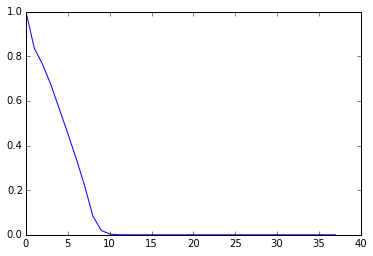

In [24]:
i=10
x = X.iloc[i]
prob = model.predict_survival_function(x.drop(['T','E']).reshape((1,-1)))
# There may not be a prediction for every month.  Also, the predictions may not be monotonically decreasing.
# Isotonic regression can solve both problems.
ir = IsotonicRegression(increasing=False, out_of_bounds='clip')
ir.fit(prob.index * x.term, prob[0])
survivalByMonth = ir.transform(np.arange(0,x.term+2))
survivalByMonth[0] = 1
survivalByMonth[-1] = 0

p = -np.diff(survivalByMonth)
totalIncome = samp.installment.iloc[i] * np.arange(0,x.term+1)
ev = np.sum(p * totalIncome)
variance = np.sum(p * totalIncome**2) - ev**2
stdev = np.sqrt(variance)
print(ev, variance, stdev)
plt.plot(survivalByMonth)

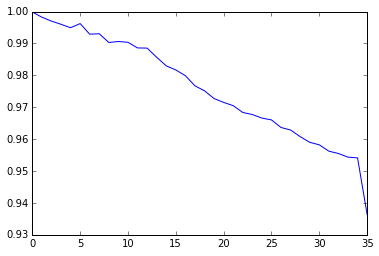

In [159]:
f = InterpolatedUnivariateSpline(prob.index * x.term, prob[0], k=1)
cumulativeHazardByMonth = f(np.arange(1,x.term+1))
cumulativeIncome = samp.installment.iloc[i] * np.arange(1,x.term+1)
hazardByMonth = 1
np.diff(cumulativeHazardByMonth)
plt.plot(cumulativeHazardByMonth)

In [115]:
survall = model.predict_survival_function(X)
survall.shape

(54, 5250)

In [46]:
df = loans.join(outcomes, how='inner')
df.head().T

id,54734,55742,56413,57167,57245
member_id,80364,114426,129814,137225,138150
loan_amnt,25000,7000,7000,25000,1200
funded_amnt,25000,7000,7000,25000,1200
funded_amnt_inv,19080.06,672.8038,0.007493834,24725,1200
term,36 months,36 months,36 months,36 months,36 months
int_rate,11.89%,10.71%,16.08%,16.99%,13.11%
installment,829.1,228.22,246.38,891.2,40.5
grade,B,B,F,D,C
sub_grade,B4,B5,F2,D3,C2
emp_title,NaN,CNN,"Health Net, Inc.",Web Programmer,city of beaumont texas


In [9]:
loans = pandas.read_csv("LoanStats3.csv",
                        encoding='utf-8',
                        parse_dates=['issue_d','last_pymnt_d','next_pymnt_d','last_credit_pull_d'],
                        index_col=0,
                        infer_datetime_format=True,
                        low_memory=True,
                        na_values = '*')

In [11]:
#loans.iloc[1]
#olddtypes = loans.dtypes
#loan = loans.loc[1077501]
loans.count()



member_id                      550564
loan_amnt                      550564
funded_amnt                    550564
funded_amnt_inv                550564
term                           550564
int_rate                       550564
installment                    550564
grade                          550564
sub_grade                      550564
emp_title                      518337
emp_length                     550564
home_ownership                 550564
annual_inc                     550560
verification_status            550564
issue_d                        550564
loan_status                    550564
pymnt_plan                     550564
url                            550564
desc                           126001
purpose                        550564
title                          550545
zip_code                       550564
addr_state                     550564
dti                            550564
delinq_2yrs                    550535
earliest_cr_line               550535
fico_range_l

In [12]:
mb = MonthBegin()
loans.issue_d = loans.issue_d.map(lambda d: d-mb)

In [14]:
#loans.dtypes
#DataFrame({'v1':olddtypes, 'v2':loans.dtypes})
#loans.set_index(loans.id)
riskFreeRates = pandas.read_csv("data/RiskFreeRates.csv",
                        encoding='utf-8',
                        parse_dates=['observation_date'],
                        index_col=0,
                        infer_datetime_format=True)

In [26]:
connection = monetdb.sql.connect(username="monetdb", password="monetdb", hostname="localhost", database="demo")

In [35]:
riskFreeRates.loc[loans.iloc[0].issue_d]
#loan.term == ' 36 months'
#riskFreeRates
#loans.issue_d
outcomedf.to_csv("outcomes.csv")

In [30]:
cursor = connection.cursor()
cursor.arraysize = 1000
sql = """
    SELECT
        loan_id,
        mob,
        case when pco_recovery_investors is not null then
            pco_recovery_investors - pco_collection_fee_investors
        else
            0
        end + received_amt_investors as received,
        due_amt_investors as due,
        pbal_beg_period_investors as balance,
        period_end_lstat
    FROM history_inv
    --WHERE loan_id in (1077501, 1077430, 1075358)
"""
cursor.execute(sql)

output = []
prev_loan_id = -1
row = cursor.fetchone() 
while row is not None:
    loan_id, mob, received, due, balance, status = row
    #print row
    if loan_id != prev_loan_id:
        # Output previous loan stats
        if prev_loan_id != -1:
            output.append((prev_loan_id, finalStatus, prev_mob, missedPayment, firstMissed, dueWhenFirstMissed, receivedAfterMissed, riskFreeRate, npv/investment))
        
        # Set up for new loan
        loan = loans.loc[loan_id]
        if loan.term == ' 36 months':
            riskFreeRate = riskFreeRates.loc[loan.issue_d].treasury3year
        else:
            riskFreeRate = riskFreeRates.loc[loan.issue_d].treasury5year
        monthlyDiscountRate = (1 + riskFreeRate/100) ** (1/12)

        investment = loan.funded_amnt_inv
        npv = -investment
        prev_mob = -1
        prev_loan_id = loan_id
        firstMissed = -1
        missedPayment = False
        receivedAfterMissed = 0
        dueWhenFirstMissed = 0
        
    # Skip duplicate rows
    if mob == prev_mob: 
        next
    prev_mob = mob
    finalStatus = status
        
    npv += received / (monthlyDiscountRate ** mob)
    totalMonths = mob
    if missedPayment:
        receivedAfterMissed += received
    if not missedPayment and due>0 and received/due < 0.99:
        firstMissed = mob
        missedPayment = True
        dueWhenFirstMissed = balance
        
    row = cursor.fetchone()

output.append((prev_loan_id, finalStatus, prev_mob, missedPayment, firstMissed, dueWhenFirstMissed, receivedAfterMissed, riskFreeRate, npv/investment))
outcomedf = DataFrame.from_records(output, index='loan_id',
    columns=['loan_id', 'finalStatus', 'monthsObserved', 'missedPayment', 'firstMissed', 'dueWhenFirstMissed', 'receivedAfterMissed', 'riskFreeRate', 'npv'])

,finalStatus,monthsObserved,missedPayment,firstMissed,dueWhenFirstMissed,receivedAfterMissed,riskFreeRate,npv
loan_id,,,,,,,,
54734,Fully Paid,26,False,-1,0.000000,0.000000,1.65,0.148251
55742,Fully Paid,36,False,-1,0.000000,0.000000,2.69,0.126973
56413,Charged Off,14,True,6,0.006655,0.000000,2.23,-0.824981
57167,Default,7,True,4,23108.329138,0.000000,0.93,-0.891443
57245,Fully Paid,36,False,-1,0.000000,0.000000,1.51,0.189126
57416,Fully Paid,36,False,-1,0.000000,0.000000,1.32,0.201242
58524,Fully Paid,22,False,-1,0.000000,0.000000,0.37,0.258714
58915,Fully Paid,36,False,-1,0.000000,0.000000,2.23,0.124412
59006,Fully Paid,36,False,-1,0.000000,0.000000,1.48,0.210130
